# Notes

## Learning
- Check Ressources OC à utiliser au début : https://openclassrooms.com/fr/paths/795/projects/1517/resources

- Helping ressources :
    - DEEPSEEK : https://www.datacamp.com/blog/deepseek-r1?utm_source=marketo&utm_medium=email&utm_campaign=250128_1-012825newsletter_2-b2b_3-all_4-na_5-bl_6-deepseek_7-en_8-emal-mk_9-na_10-bau_11-email&utm_content=blast&utm_term=lead-news&mkt_tok=MzA3LU9BVC05NjgAAAGYTGlVnPRJCH2k2X9MdUIIyqH8eTVHXb-2m8bzXkiGTU4DAFuCDKVBjwXThnNgSL_P6U1Cqa985CCug5Cvx0jfShQ-MEvPWa-6X9XtTCrpavWoqg
    - Model + Metrics + Display avec changement d'encodeur en supplément : https://www.geeksforgeeks.org/image-segmentation-using-tensorflow/
    - Guide to Convolution arithmetics -31 p- : https://arxiv.org/pdf/1603.07285
    - Cours CS231n :
        - CNN : https://cs231n.github.io/convolutional-networks/
        - Understanding & visualizing CNN : https://cs231n.github.io/understanding-cnn/
        - Transfer Learning : https://cs231n.github.io/transfer-learning/
    - Image Segmentation with pretrained model with HuggingFace & Tensorflow
        - https://www.youtube.com/watch?v=oL-xmufhZM8
        - https://huggingface.co/docs/transformers/tasks/semantic_segmentation
        - SOTA models huggingface : https://huggingface.co/blog/mask2former
        - Fine-tuning segformer : https://huggingface.co/blog/fine-tune-segformer
    - UNET : https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
    - Albumentations : https://albumentations.ai/docs/examples/example/
- Analyse pré-exploratoire et préparation des données
    - Regarder l'équilibre des catégories avant le train-test-split ? Possible avec np.unique_counts(img_array) sur chaque image (se servir du multiprocessing)
    - Crée le train test split avec shuffle et 0.2

## Workflow
https://docs.google.com/document/d/1kIbxaqzdPZqHEJRxwuFCAar-G8W78VFRgDUEF5Mesjw/edit?invite=CI_q4swC&tab=t.0


## To-Do
- Prétraitement des données
    - Normalisation des images RGB (vérifier si c'est fait avec load_img)

- Datagenerator (tf.keras.utils.PyDataset) : https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    - Dans le init, argument pour dossier + str endswith pour les images et les masks (`le def doit être dans le init`)
    - A partir de çà générer avec une fonction interne les indexes des images pour le shuffle
    - Faire une classe DataGenerator unique
        - avec multiprocessing as a function to call internally et ajouter un arg external_multiprocessing. Si external_multiprocessing = True, set use_multiprocessing = False dans le DataGenerator
        - avec un argument pour le transform to categorical (si true, alors on fait le to_categorical sur les labels)
    - Ajouter la normalisation sur le RGB si nécessaire dans load_img
    - Ajouter la mapping (en valeur fixe dans init) sur le mask avec np.vectorize + le dictionnaire
    - Ajouter le on_epoch_end pour shuffle les données à chaque epoch sur la liste des indexs (créer une fonction interne pour l'extraction des indexes)
    - Mettre uniquement le path du dossier dans le DataGenerator et non les images directement (pour pouvoir changer de dataset plus facilement) - cela permets de récupérer les indexes des images pour le shuffle
    - Ajouter la partie data augmentation (rotation, flip, zoom, etc.)
    - Appliquer le data loader ensuite sur train - val - test

- Datagenerator (tf.data.Dataser)
    - Adapter le DataGenerator pour tf.data.Dataset
    - Internaliser les fonctions dans la classe
    - Ajouter le mapping (en valeur fixe dans init) sur le mask avec tf.lookup
    - Remplacer la partie mapping avec np vectorize par tf.lookup (voir email pour le code)

- Modele
    - Tester avec fit generator pour les perfs ? : https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/  ou https://stackoverflow.com/questions/55531427/how-to-define-max-queue-size-workers-and-use-multiprocessing-in-keras-fit-gener

- Ajouter les métriques IoU et Dice
    - Ajouter les métriques IoU et Dice dans le modèle
    - Ajouter les métriques IoU et Dice dans le callback

# Future comms

##  **Les différents types de segmentation**
---

Un modèle de segmentation d'image génère en sortie une carte de segmentation où chaque pixel est classifié dans une catégorie spécifique. La structure de la couche de sortie dépend du type de segmentation :


### **1. Segmentation sémantique (ex : UNet, DeepLabV3)**
Chaque pixel appartient à une classe parmi un nombre fixe de classes.

- **Couche de sortie** : une convolution 2D avec autant de canaux que de classes (`Conv2D(num_classes, kernel_size=1)`).  
- **Tenseur de sortie** : `[batch_size, height, width, num_classes]`.  
- **Post-traitement** : on applique une fonction **softmax** (multiclasses) ou **sigmoïde** (binaire) pour obtenir des probabilités.  
- **Prédiction finale** : l'index du canal ayant la probabilité la plus élevée pour chaque pixel.  

💡 **Exemple en segmentation binaire (ex : fond vs objet)**  
- Dernière couche : `Conv2D(1, kernel_size=1, activation="sigmoid")`  
- La sortie est de forme `[batch_size, height, width, 1]` avec des valeurs entre 0 et 1 (probabilité d'appartenir à la classe positive).

💡 **Exemple en segmentation multiclasse (ex : route, voiture, ciel, etc.)**  
- Dernière couche : `Conv2D(num_classes, kernel_size=1, activation="softmax")`  
- La sortie est `[batch_size, height, width, num_classes]`, et on prend `argmax` sur l'axe des classes.


### **2. Segmentation instance (ex : Mask R-CNN)**
Chaque instance d'un objet a un identifiant unique.

- **Sortie plus complexe** :  
  - Une **carte de segmentation** par objet détecté (`[batch_size, num_objects, height, width]`).  
  - Une **carte des scores** (`[batch_size, num_objects]`) pour indiquer la confiance de chaque masque.  
  - Une **boîte englobante** pour chaque instance.  

Ici, chaque pixel peut appartenir à plusieurs objets en même temps, contrairement à la segmentation sémantique.


### **Résumé**
| Type de segmentation | Forme de sortie | Activation | Post-traitement |
|----------------------|----------------|------------|-----------------|
| **Binaire** | `[batch, h, w, 1]` | Sigmoïde | Seuil (0.5) |
| **Multiclasse** | `[batch, h, w, num_classes]` | Softmax | `argmax` sur classes |
| **Instance** | `[batch, num_objects, h, w]` + scores | Variable | Seuil + NMS |

## **Présentation de UNET**

---

**UNet**, un modèle bien connu pour la segmentation sémantique. Ce modèle prend une image RGB de **256x512x3** et renvoie une carte de segmentation de **256x512x8** avec 8 classes.  

### **Architecture du modèle :**
- Encodeur basé sur **convolutions** + **max pooling** pour extraire les features.
- Décodeur avec **upsampling** pour revenir à la résolution d'origine.
- Dernière couche avec **8 canaux** et activation **softmax** pour obtenir une distribution de probabilité sur les classes.



### **Explication de la sortie :**
- La dernière couche `Conv2D(8, (1,1), activation="softmax")` génère un tenseur **(256, 512, 8)**.
- Chaque pixel contient un vecteur de **8 probabilités** (une par classe).
- Pour obtenir l’image segmentée finale, on prend `argmax` sur l’axe des classes pour assigner chaque pixel à la classe la plus probable.


### **Résumé :**
✅ **Entrée** : Image `(256,512,3)`  
✅ **Sortie** : Carte de segmentation `(256,512,8)`  
✅ **Activation finale** : `softmax` pour classification pixel par pixel  
✅ **Post-traitement** : `argmax` pour obtenir la classe de chaque pixel  

## **Format des labels de sortie pour la segmentation**

---

Le format des labels dépend de la **fonction de perte** utilisée. Comme ta couche de sortie utilise une activation **softmax** et génère une sortie `(num_batches, 256, 512, 8)`, voici les deux options possibles :  


### **1️⃣ Labels sous forme d’index : `(num_batches, 256, 512)`**  
👉 **Format :** Chaque pixel est représenté par un entier correspondant à l'index de sa classe (0 à 7).  
👉 **Fonction de perte :** `SparseCategoricalCrossentropy(from_logits=False)`  

**Exemple d'un batch de labels :**  
```python
y_true.shape  # (num_batches, 256, 512), dtype=int
y_true[0, 100, 200]  # Exemple : 3 (classe 3 assignée au pixel (100,200))
```

✅ **Avantages** :
- Plus léger en mémoire.  
- Pas besoin de conversion avant l’entraînement.  

🚀 **Comment charger les labels ?**  
```python
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
```


### **2️⃣ Labels en one-hot : `(num_batches, 256, 512, 8)`**  
👉 **Format :** Chaque pixel est représenté par un vecteur de probabilité où une seule position est à 1 (one-hot encoding).  
👉 **Fonction de perte :** `CategoricalCrossentropy(from_logits=False)`  

**Exemple d'un pixel encodé en one-hot (classe 3)** :  
```python
[0, 0, 0, 1, 0, 0, 0, 0]  # Classe 3 activée
```

✅ **Avantages** :
- Permet de travailler avec des **poids de classes** si les classes sont déséquilibrées.  
- Peut être plus stable pour certaines architectures.  

🚀 **Comment charger les labels ?**  
```python
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
```
💡 Si tes labels sont sous forme `(num_batches, 256, 512)`, il faut les **convertir en one-hot** avant l’entraînement :  
```python
y_true_onehot = tf.one_hot(y_true, depth=8)  # Convertit (batch, 256, 512) → (batch, 256, 512, 8)
```



### **📌 Quelle approche choisir ?**  
✅ **Si tes labels sont stockés comme une image avec une seule valeur par pixel** → **`SparseCategoricalCrossentropy`** (option 1, plus simple).  
✅ **Si tu veux manipuler les probabilités ou ajuster les poids des classes** → **`CategoricalCrossentropy`** (option 2, one-hot).  

🚀 **Recommandation :** Utilise la première approche `(num_batches, 256, 512)` car elle est plus efficace en mémoire et plus simple à gérer.  


# Code

In [32]:
from pathlib import Path
import os
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from collections import namedtuple
import seaborn as sns
import multiprocessing

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Présentation des données 

**====================  Dossier `Raw`  ====================**


Le jeu de données utilisé pour la conception du modèle de segmentation d'images est composé de deux répertoires:
- Un répertoire `gtFine` contenant les images de masques annotées (20 000 fichiers). Chaque image se distingue par 4 fichiers différents:
    - Un fichier `color` en couleurs (5 000 fichiers png)
    - Un fichier `instanceIds` en niveaux de gris (5 000 fichiers png)
    - Un fichier `labelIds` en niveaux de gris (5 000 fichiers png)
    - Un fichier `polygons` contenant les coordonnées des zones segmentéees (5 000 fichiers json)
- Un répertoire `leftImg8bit` contenant les images brutes en couleurs (5 000 fichiers)


Chacun de ces répertoires est ensuite subdivisé en trois sous répertoires, qui eux mêmes contiennent des sous-répertoires en fonction des villes:
- `train` contenant les données d'entraînement (2975 images)
- `val` contenant les données de validation  (500 images)
- `test` dont les annotations ne sont pas rendues publiques, donc inexploitables dans le cas présent (1525 images)


Pour plus d'informations sur le dataset, merci de lire le README suivant : https://github.com/mcordts/cityscapesScripts/blob/master/README.md

**====================  Dossier `Sorted`  ====================**


La première étape consiste à préparer les dossiers pour le jeu d'entraînement, de validation et de test dans ce nouveau dossier.<br>
Premièrement, on ignore les dossiers de test puisque nous n'avons pas accès aux annotations.<br>


Après ces étapes de préparation, le dossier `Sorted` contiendra les données suivantes:
- Un répertoire `train` contenant uniquement les fichiers d'images et de masques d'entraînement en niveaux de gris `labelIds` et en couleur `color` soit un total de 2975 * 3 = 8925 fichiers
- Un répertoire `test` contenant uniquement les fichiers d'images et de masques de validation du dossier `val` en niveaux de gris `labelIds` et en couleur `color` soit un total de 500 * 3 = 1500 fichiers


Commençons par vérifier que nous avons bien toutes les données après avoir exécutées les commandes bash dans le terminal:

In [2]:
# Path to the root directory
root_dir = Path.cwd().parent
# Path to the train directory
train_dir = root_dir / "data" / "Sorted" / "train"
# Path to the test directory
test_dir = root_dir / "data" / "Sorted" / "test"
# Print the number of files after sorting the files
print("Train files: ", len(os.listdir(train_dir)))
print("Test files: ", len(os.listdir(test_dir)))

Train files:  8925
Test files:  1500


In [4]:
# Get the filepath of the train images and masks
train_images = [
    str(train_dir / img)
    for img in sorted(os.listdir(train_dir))
    if img.endswith("leftImg8bit.png")
]
train_masks_grey = [
    str(train_dir / mask)
    for mask in sorted(os.listdir(train_dir))
    if mask.endswith("labelIds.png")
]
train_masks_rgb = [
    str(train_dir / mask)
    for mask in sorted(os.listdir(train_dir))
    if mask.endswith("color.png")
]
# Get the filepath of the test images and masks
test_images = [
    str(test_dir / img)
    for img in sorted(os.listdir(test_dir))
    if img.endswith("leftImg8bit.png")
]
test_masks_grey = [
    str(test_dir / mask)
    for mask in sorted(os.listdir(test_dir))
    if mask.endswith("labelIds.png")
]
test_masks_rgb = [
    str(test_dir / mask)
    for mask in sorted(os.listdir(test_dir))
    if mask.endswith("color.png")
]

In [5]:
print(len(train_images), len(train_masks_grey), len(train_masks_rgb))
print(len(test_images), len(test_masks_grey), len(test_masks_rgb))

2975 2975 2975
500 500 500


In [6]:
print(train_images[0], train_masks_grey[0], train_masks_rgb[0])
print(train_images[-1], train_masks_grey[-1], train_masks_rgb[-1])

/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000000_000019_leftImg8bit.png /home/hedredo/github/oc_p8/data/Sorted/train/aachen_000000_000019_gtFine_labelIds.png /home/hedredo/github/oc_p8/data/Sorted/train/aachen_000000_000019_gtFine_color.png
/home/hedredo/github/oc_p8/data/Sorted/train/zurich_000121_000019_leftImg8bit.png /home/hedredo/github/oc_p8/data/Sorted/train/zurich_000121_000019_gtFine_labelIds.png /home/hedredo/github/oc_p8/data/Sorted/train/zurich_000121_000019_gtFine_color.png


In [7]:
print(test_images[0], test_masks_grey[0], test_masks_rgb[0])
print(test_images[-1], test_masks_grey[-1], test_masks_rgb[-1])

/home/hedredo/github/oc_p8/data/Sorted/test/frankfurt_000000_000294_leftImg8bit.png /home/hedredo/github/oc_p8/data/Sorted/test/frankfurt_000000_000294_gtFine_labelIds.png /home/hedredo/github/oc_p8/data/Sorted/test/frankfurt_000000_000294_gtFine_color.png
/home/hedredo/github/oc_p8/data/Sorted/test/munster_000173_000019_leftImg8bit.png /home/hedredo/github/oc_p8/data/Sorted/test/munster_000173_000019_gtFine_labelIds.png /home/hedredo/github/oc_p8/data/Sorted/test/munster_000173_000019_gtFine_color.png


In [8]:
Label = namedtuple(
    "Label",
    [
        "name",
        "id",
        "trainId",
        "category",
        "categoryId",
        "hasInstances",
        "ignoreInEval",
        "color",
    ],
)

labels = [
    Label("unlabeled", 0, 255, "void", 0, False, True, (0, 0, 0)),
    Label("ego vehicle", 1, 255, "void", 0, False, True, (0, 0, 0)),
    Label("rectification border", 2, 255, "void", 0, False, True, (0, 0, 0)),
    Label("out of roi", 3, 255, "void", 0, False, True, (0, 0, 0)),
    Label("static", 4, 255, "void", 0, False, True, (0, 0, 0)),
    Label("dynamic", 5, 255, "void", 0, False, True, (111, 74, 0)),
    Label("ground", 6, 255, "void", 0, False, True, (81, 0, 81)),
    Label("road", 7, 0, "flat", 1, False, False, (128, 64, 128)),
    Label("sidewalk", 8, 1, "flat", 1, False, False, (244, 35, 232)),
    Label("parking", 9, 255, "flat", 1, False, True, (250, 170, 160)),
    Label("rail track", 10, 255, "flat", 1, False, True, (230, 150, 140)),
    Label("building", 11, 2, "construction", 2, False, False, (70, 70, 70)),
    Label("wall", 12, 3, "construction", 2, False, False, (102, 102, 156)),
    Label("fence", 13, 4, "construction", 2, False, False, (190, 153, 153)),
    Label("guard rail", 14, 255, "construction", 2, False, True, (180, 165, 180)),
    Label("bridge", 15, 255, "construction", 2, False, True, (150, 100, 100)),
    Label("tunnel", 16, 255, "construction", 2, False, True, (150, 120, 90)),
    Label("pole", 17, 5, "object", 3, False, False, (153, 153, 153)),
    Label("polegroup", 18, 255, "object", 3, False, True, (153, 153, 153)),
    Label("traffic light", 19, 6, "object", 3, False, False, (250, 170, 30)),
    Label("traffic sign", 20, 7, "object", 3, False, False, (220, 220, 0)),
    Label("vegetation", 21, 8, "nature", 4, False, False, (107, 142, 35)),
    Label("terrain", 22, 9, "nature", 4, False, False, (152, 251, 152)),
    Label("sky", 23, 10, "sky", 5, False, False, (70, 130, 180)),
    Label("person", 24, 11, "human", 6, True, False, (220, 20, 60)),
    Label("rider", 25, 12, "human", 6, True, False, (255, 0, 0)),
    Label("car", 26, 13, "vehicle", 7, True, False, (0, 0, 142)),
    Label("truck", 27, 14, "vehicle", 7, True, False, (0, 0, 70)),
    Label("bus", 28, 15, "vehicle", 7, True, False, (0, 60, 100)),
    Label("caravan", 29, 255, "vehicle", 7, True, True, (0, 0, 90)),
    Label("trailer", 30, 255, "vehicle", 7, True, True, (0, 0, 110)),
    Label("train", 31, 16, "vehicle", 7, True, False, (0, 80, 100)),
    Label("motorcycle", 32, 17, "vehicle", 7, True, False, (0, 0, 230)),
    Label("bicycle", 33, 18, "vehicle", 7, True, False, (119, 11, 32)),
    Label("license plate", -1, -1, "vehicle", 7, False, True, (0, 0, 142)),
]


In [10]:
len(labels)

35

In [9]:
i_test = 1

In [10]:
mask = tf.keras.utils.load_img(train_masks_grey[i_test], color_mode="grayscale")
mask_array = tf.keras.utils.img_to_array(mask)
print(mask_array.shape)

(1024, 2048, 1)


In [11]:
H, W, C = mask_array.shape
RESIZE_RATIO = 0.25
print(
    "New Target Shape with resize ratio of " + str(RESIZE_RATIO) + " is: ",
    TARGET_SIZE := (int(H * RESIZE_RATIO), int(W * RESIZE_RATIO)),
)
print("Number of CPU cores available: ", NUM_WORKERS := os.cpu_count())


New Target Shape with resize ratio of 0.25 is:  (256, 512)
Number of CPU cores available:  16


In [15]:
train_masks_grey[:128]
train_images[:128]

['/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000000_000019_leftImg8bit.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000001_000019_leftImg8bit.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000002_000019_leftImg8bit.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000003_000019_leftImg8bit.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000004_000019_leftImg8bit.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000005_000019_leftImg8bit.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000006_000019_leftImg8bit.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000007_000019_leftImg8bit.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000008_000019_leftImg8bit.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000009_000019_leftImg8bit.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000010_000019_leftImg8bit.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_

In [ ]:
# np.unique_counts(arr)

UniqueCountsResult(values=array([ 0.,  1.,  3.,  4.,  7.,  8., 11., 17., 20., 21., 22., 23., 24.,
       25., 26., 33.], dtype=float32), counts=array([    1,  5255,  1532,   909, 52035,  1852, 38361,  1439,  2168,
       13882,  8119,  2444,    97,   145,  2691,   142]))

In [12]:
class Dataloaderv1(tf.keras.utils.PyDataset):
    def __init__(self, images, masks, batch_size, target_size, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.num_samples = len(images)
        self.target_size = target_size

    def __len__(self):
        length = math.ceil(self.num_samples / self.batch_size)
        print(f"Number of batches: {length}")
        return length

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)

        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        batch_images = self.images[start_idx:end_idx]
        batch_masks = self.masks[start_idx:end_idx]

        print(f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}")

        batch_images = [
            tf.keras.utils.load_img(
                img,
                target_size=self.target_size,
                color_mode="rgb",
                interpolation="bilinear",
            )
            for img in batch_images
        ]
        batch_images = [tf.keras.utils.img_to_array(img) for img in batch_images]

        batch_masks = [
            tf.keras.utils.load_img(
                mask,
                target_size=self.target_size,
                color_mode="grayscale",
                interpolation="nearest",
            )
            for mask in batch_masks
        ]
        batch_masks = [
            tf.keras.utils.img_to_array(mask).squeeze() for mask in batch_masks
        ]

        return np.asarray(batch_images), np.asarray(batch_masks)

In [13]:
class Dataloaderv2(tf.keras.utils.PyDataset):
    def __init__(self, images, masks, batch_size, target_size, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.num_samples = len(images)
        self.target_size = target_size

    def __len__(self):
        length = math.ceil(self.num_samples / self.batch_size)
        print(f"Number of batches: {length}")
        return length

    def load_img_to_array(self, img_path):
        img = tf.keras.utils.load_img(
            img_path,
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        return tf.keras.utils.img_to_array(img)

    def load_mask_to_array(self, mask_path):
        mask = tf.keras.utils.load_img(
            mask_path,
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        return tf.keras.utils.img_to_array(mask).squeeze()

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)

        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        batch_images = self.images[start_idx:end_idx]
        batch_masks = self.masks[start_idx:end_idx]

        print(f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}")

        with multiprocessing.Pool(self.workers) as pool:
            batch_images = pool.map(self.load_img_to_array, batch_images)
            batch_masks = pool.map(self.load_mask_to_array, batch_masks)

        return np.asarray(batch_images), np.asarray(batch_masks)

In [14]:
class Dataloaderv2b(tf.keras.utils.Sequence):
    def __init__(self, images, masks, batch_size, target_size, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_samples = len(images)

    def __len__(self):
        length = math.ceil(self.num_samples / self.batch_size)
        print(f"Number of batches: {length}")
        return length

    def load_img_to_array(self, img_path):
        img = tf.keras.utils.load_img(
            img_path,
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        return tf.keras.utils.img_to_array(img)

    def load_mask_to_array(self, mask_path):
        mask = tf.keras.utils.load_img(
            mask_path,
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        return tf.keras.utils.img_to_array(mask).squeeze()

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)
        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")
        batch_images = self.images[start_idx:end_idx]
        batch_masks = self.masks[start_idx:end_idx]
        print(f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}")

        # Traitement séquentiel ici
        batch_images = [self.load_img_to_array(img) for img in batch_images]
        batch_masks = [self.load_mask_to_array(mask) for mask in batch_masks]

        return np.asarray(batch_images), np.asarray(batch_masks)

In [15]:
class Dataloaderv2c(tf.keras.utils.Sequence):
    def __init__(self, images, masks, batch_size, target_size, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_samples = len(images)

    def __len__(self):
        length = math.ceil(self.num_samples / self.batch_size)
        print(f"Number of batches: {length}")
        return length

    def load_img_to_array(self, img_path):
        img = tf.keras.utils.load_img(
            img_path,
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        return tf.keras.utils.img_to_array(img)

    def load_mask_to_array(self, mask_path):
        mask = tf.keras.utils.load_img(
            mask_path,
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        return tf.keras.utils.img_to_array(mask).squeeze()

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)
        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")
        batch_images = self.images[start_idx:end_idx]
        batch_masks = self.masks[start_idx:end_idx]
        print(f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}")

        images, masks = [], []
        # Traitement séquentiel ici
        for img, mask in zip(batch_images, batch_masks):
            images.append(self.load_img_to_array(img))
            masks.append(self.load_mask_to_array(mask))

        return np.asarray(images), np.asarray(masks)

In [16]:
class Dataloaderv3(tf.keras.utils.PyDataset):
    def __init__(self, images, masks, batch_size, target_size, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.num_samples = len(images)
        self.num_classes = num_classes
        self.target_size = target_size

    def __len__(self):
        length = math.ceil(self.num_samples / self.batch_size)
        print(f"Number of batches: {length}")
        return length

    def load_img_to_array(self, img_path):
        img = tf.keras.utils.load_img(
            img_path,
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        return tf.keras.utils.img_to_array(img)

    def load_mask_to_array(self, mask_path):
        mask = tf.keras.utils.load_img(
            mask_path,
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        return tf.keras.utils.img_to_array(mask).squeeze()

    def transform_mask_to_categorical(self, mask):
        return tf.keras.utils.to_categorical(mask, num_classes=self.num_classes)

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)

        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        batch_images = self.images[start_idx:end_idx]
        batch_masks = self.masks[start_idx:end_idx]

        print(f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}")

        with multiprocessing.Pool(self.workers) as pool:
            batch_images = pool.map(self.load_img_to_array, batch_images)
            batch_masks = pool.map(self.load_mask_to_array, batch_masks)

        return np.asarray(batch_images), np.asarray(batch_masks)

In [17]:
class Dataloaderv3_(tf.keras.utils.PyDataset):
    def __init__(self, images, masks, batch_size, target_size, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.num_samples = len(images)
        self.num_classes = num_classes
        self.target_size = target_size

    def __len__(self):
        length = math.ceil(self.num_samples / self.batch_size)
        print(f"Number of batches: {length}")
        return length

    def load_img_to_array(self, img_path):
        img = tf.keras.utils.load_img(
            img_path,
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        return tf.keras.utils.img_to_array(img)

    def load_mask_to_array(self, mask_path):
        mask = tf.keras.utils.load_img(
            mask_path,
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        return tf.keras.utils.img_to_array(mask).squeeze()

    def transform_mask_to_categorical(self, mask):
        return tf.keras.utils.to_categorical(mask, num_classes=self.num_classes)

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)

        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        batch_images = self.images[start_idx:end_idx]
        batch_masks = self.masks[start_idx:end_idx]

        print(f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}")

        with multiprocessing.Pool(self.workers) as pool:
            batch_images = pool.map(self.load_img_to_array, batch_images)
            batch_masks = pool.map(self.load_mask_to_array, batch_masks)
            batch_masks = pool.map(self.transform_mask_to_categorical, batch_masks)

        return np.asarray(batch_images), np.asarray(batch_masks)

In [18]:
class Dataloaderv3b(tf.keras.utils.PyDataset):
    def __init__(self, images, masks, batch_size, target_size, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.num_samples = len(images)
        self.num_classes = num_classes
        self.target_size = target_size

    def __len__(self):
        length = math.ceil(self.num_samples / self.batch_size)
        print(f"Number of batches: {length}")
        return length

    def load_img_to_array(self, img_path):
        img = tf.keras.utils.load_img(
            img_path,
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        return tf.keras.utils.img_to_array(img)

    def load_mask_to_array(self, mask_path):
        mask = tf.keras.utils.load_img(
            mask_path,
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        return tf.keras.utils.img_to_array(mask).squeeze()

    def transform_mask_to_categorical(self, mask):
        return tf.keras.utils.to_categorical(mask, num_classes=self.num_classes)

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)

        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        batch_images = self.images[start_idx:end_idx]
        batch_masks = self.masks[start_idx:end_idx]

        print(f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}")

        # Traitement séquentiel ici
        batch_images = [self.load_img_to_array(img) for img in batch_images]
        batch_masks = [self.load_mask_to_array(mask) for mask in batch_masks]

        return np.asarray(batch_images), np.asarray(batch_masks)

In [19]:
class Dataloaderv3b_(tf.keras.utils.PyDataset):
    def __init__(self, images, masks, batch_size, target_size, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.num_samples = len(images)
        self.num_classes = num_classes
        self.target_size = target_size

    def __len__(self):
        length = math.ceil(self.num_samples / self.batch_size)
        print(f"Number of batches: {length}")
        return length

    def load_img_to_array(self, img_path):
        img = tf.keras.utils.load_img(
            img_path,
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        return tf.keras.utils.img_to_array(img)

    def load_mask_to_array(self, mask_path):
        mask = tf.keras.utils.load_img(
            mask_path,
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        return tf.keras.utils.img_to_array(mask).squeeze()

    def transform_mask_to_categorical(self, mask):
        return tf.keras.utils.to_categorical(mask, num_classes=self.num_classes)

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)

        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        batch_images = self.images[start_idx:end_idx]
        batch_masks = self.masks[start_idx:end_idx]

        print(f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}")

        # Traitement séquentiel ici
        batch_images = [self.load_img_to_array(img) for img in batch_images]
        batch_masks = [
            self.transform_mask_to_categorical(
                load_mask_to_array(mask), num_classes=self.num_classes
            )
            for mask in batch_masks
        ]

        return np.asarray(batch_images), np.asarray(batch_masks)

In [19]:
%%timeit
datagen = Dataloaderv3(
    train_images[:128],
    train_masks_grey[:128],
    batch_size=64,
    target_size=TARGET_SIZE,
    num_classes=35,
    workers=NUM_WORKERS,
    use_multiprocessing=False,
)
print(datagen.num_batches)
for batch_images, batch_masks in datagen:
    print(batch_images.shape, batch_masks.shape)

Number of batches: 2
2
Fetching batch 0: start_idx=0, end_idx=64
(64, 256, 512, 3) (64, 256, 512, 35)
Fetching batch 1: start_idx=64, end_idx=128
(64, 256, 512, 3) (64, 256, 512, 35)
Number of batches: 2
2
Fetching batch 0: start_idx=0, end_idx=64
(64, 256, 512, 3) (64, 256, 512, 35)
Fetching batch 1: start_idx=64, end_idx=128
(64, 256, 512, 3) (64, 256, 512, 35)
Number of batches: 2
2
Fetching batch 0: start_idx=0, end_idx=64
(64, 256, 512, 3) (64, 256, 512, 35)
Fetching batch 1: start_idx=64, end_idx=128
(64, 256, 512, 3) (64, 256, 512, 35)
Number of batches: 2
2
Fetching batch 0: start_idx=0, end_idx=64
(64, 256, 512, 3) (64, 256, 512, 35)
Fetching batch 1: start_idx=64, end_idx=128
(64, 256, 512, 3) (64, 256, 512, 35)
Number of batches: 2
2
Fetching batch 0: start_idx=0, end_idx=64
(64, 256, 512, 3) (64, 256, 512, 35)
Fetching batch 1: start_idx=64, end_idx=128
(64, 256, 512, 3) (64, 256, 512, 35)
Number of batches: 2
2
Fetching batch 0: start_idx=0, end_idx=64
(64, 256, 512, 3) (6

In [25]:
for batch_images, batch_masks in datagen:
    print(batch_images.shape, batch_masks.shape)

Fetching batch 0: start_idx=0, end_idx=32
(32, 256, 512, 3) (32, 256, 512)
Fetching batch 1: start_idx=32, end_idx=64
(32, 256, 512, 3) (32, 256, 512)
Fetching batch 2: start_idx=64, end_idx=96
(32, 256, 512, 3) (32, 256, 512)
Fetching batch 3: start_idx=96, end_idx=128
(32, 256, 512, 3) (32, 256, 512)


In [ ]:
def __init__(self, x_set, y_set, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        # Return number of batches.
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        # Return x, y for batch idx.
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.x))
        batch_x = self.x[low:high]
        batch_y = self.y[low:high]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)

In [ ]:
img = tf.keras.utils.load_img(train_masks_grey[i])
img_array = tf.keras.utils.img_to_array(img)
print(img_array.shape)

In [10]:
# Pick a color palette for RGB labels with 7 colors (void is ignored)
sns.color_palette("tab10", 7)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)]

In [11]:
# Assign the palette with 7 colors
palette = sns.color_palette("tab10", 7)
# Create a list of tuples in 255 RGB values
colors_list = [tuple(rgb) for rgb in (np.array(palette) * 255).astype(int).tolist()]
# Add the color for void
colors_list.insert(0, (0, 0, 0))
# Then create a mapping dict
category2rgb = {label: color for label, color in zip(range(8), colors_list)}
# Print the dict
print(category2rgb)

{0: (0, 0, 0), 1: (31, 119, 180), 2: (255, 127, 14), 3: (44, 160, 44), 4: (214, 39, 40), 5: (148, 103, 189), 6: (140, 86, 75), 7: (227, 119, 194)}


In [11]:
# Create a mapping dict to replace id by category
id2category = {label.id: label.categoryId for label in labels}
# Print the dict
print(id2category)

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3, 20: 3, 21: 4, 22: 4, 23: 5, 24: 6, 25: 6, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7, 32: 7, 33: 7, -1: 7}


In [98]:
tf.constant([3, 5, 2])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 5, 2], dtype=int32)>

In [1]:
import PIL

In [100]:
# Dimensions cibles
TARGET_HEIGHT = 256
TARGET_WIDTH = 512


def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Images en couleur
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalisation
    image = tf.image.resize(
        image, [TARGET_HEIGHT, TARGET_WIDTH], method="bilinear"
    )  # Redimensionnement
    return image


def load_annotation_gris(annotation_path):
    annotation = tf.io.read_file(annotation_path)
    annotation = tf.image.decode_png(
        annotation, channels=1
    )  # Annotation en niveau de gris
    # annotation = tf.map_fn(fn= lambda x: )
    annotation = tf.image.resize(
        annotation, [TARGET_HEIGHT, TARGET_WIDTH], method="nearest"
    )  # Redimensionnement
    return annotation


def load_annotation_rgb(annotation_path):
    annotation = tf.io.read_file(annotation_path)
    annotation = tf.image.decode_png(annotation, channels=3)  # Annotation RGB
    annotation = tf.image.resize(
        annotation, [TARGET_HEIGHT, TARGET_WIDTH], method="nearest"
    )  # Redimensionnement
    return annotation


In [25]:
def load_training_data(image_path, annotation_gris_path):
    image = load_image(image_path)
    annotation_gris = load_annotation_gris(annotation_gris_path)
    return image, annotation_gris


def create_training_dataset(
    image_files, annotation_gris_files, batch_size=32, shuffle=True
):
    dataset = tf.data.Dataset.from_tensor_slices((image_files, annotation_gris_files))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_files))
    dataset = dataset.map(load_training_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [16]:
def load_visualization_data(image_path, annotation_grey_path, annotation_rgb_path):
    image = load_image(image_path)
    annotation_grey = load_annotation_gris(annotation_grey_path)
    annotation_rgb = load_annotation_rgb(annotation_rgb_path)
    return image, annotation_grey, annotation_rgb


def create_visualization_dataset(
    image_files, annotation_rgb_files, batch_size=32, shuffle=False
):
    dataset = tf.data.Dataset.from_tensor_slices((image_files, annotation_rgb_files))
    dataset = dataset.map(load_visualization_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [17]:
class PixelClassificationDataset:
    def __init__(
        self, image_files, annotation_gris_files, annotation_rgb_files, batch_size=32
    ):
        self.image_files = image_files
        self.annotation_gris_files = annotation_gris_files
        self.annotation_rgb_files = annotation_rgb_files
        self.batch_size = batch_size

        # Créer les datasets
        self.train_ds = self._create_training_dataset()
        self.visualization_ds = self._create_visualization_dataset()

    def _create_training_dataset(self):
        dataset = tf.data.Dataset.from_tensor_slices(
            (self.image_files, self.annotation_gris_files)
        )
        dataset = dataset.shuffle(buffer_size=len(self.image_files))
        dataset = dataset.map(load_training_data, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return dataset

    def _create_visualization_dataset(self):
        dataset = tf.data.Dataset.from_tensor_slices(
            (self.image_files, self.annotation_gris_files, self.annotation_rgb_files)
        )
        dataset = dataset.map(
            load_visualization_data, num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return dataset

    def get_training_dataset(self):
        return self.train_ds

    def get_visualization_dataset(self):
        return self.visualization_ds


In [101]:
# Utilisation
dataset_handler = PixelClassificationDataset(
    train_images, train_masks_grey, train_masks_rgb, batch_size=32
)
train_ds = dataset_handler.get_training_dataset()
visual_ds = dataset_handler.get_visualization_dataset()

In [102]:
type(train_ds), type(visual_ds)

(tensorflow.python.data.ops.prefetch_op._PrefetchDataset,
 tensorflow.python.data.ops.prefetch_op._PrefetchDataset)

In [103]:
# Load a batch of visualization data
for image, annotation_grey, annotation_rgb in visual_ds.take(1):
    print(image.shape, annotation_grey.shape, annotation_rgb.shape)
    test_image = image[0]
    test_annotation_grey = annotation_grey[0]
    test_annotation_rgb = annotation_rgb[0]

(32, 256, 512, 3) (32, 256, 512, 1) (32, 256, 512, 3)


In [61]:
# Check the unique value in the annotation_grey
np.unique(test_annotation_grey.numpy())

array([ 0,  1,  3,  4,  7,  8, 11, 17, 20, 21, 22, 23, 24, 25, 26, 33],
      dtype=uint8)

In [62]:
train_images[0], train_masks_grey[0], train_masks_rgb[0]

('/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000000_000019_leftImg8bit.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000000_000019_gtFine_labelIds.png',
 '/home/hedredo/github/oc_p8/data/Sorted/train/aachen_000000_000019_gtFine_color.png')

In [63]:
image = tf.io.read_file(train_masks_grey[0])
image = tf.image.decode_png(image, channels=1)
sq_img = image.numpy().squeeze()
print(sq_img.shape)
# list the unique values of sq img
np.unique(sq_img)

(1024, 2048)


array([ 0,  1,  3,  4,  7,  8, 11, 17, 20, 21, 22, 23, 24, 25, 26, 33],
      dtype=uint8)

In [64]:
image = tf.io.read_file(train_masks_rgb[0])
image = tf.image.decode_png(image, channels=3)
sq_img = image.numpy().squeeze()
print(sq_img.shape)
# list the unique values of sq img
np.unique(sq_img)

(1024, 2048, 3)


array([  0,  11,  20,  32,  35,  60,  64,  70, 107, 119, 128, 130, 142,
       152, 153, 180, 220, 232, 244, 251, 255], dtype=uint8)

In [65]:
from matplotlib.colors import ListedColormap

# Convertir les couleurs RGB de 0-255 à 0-1
colors = [tuple(np.array(color) / 255.0) for color in category2rgb.values()]

# Créer une colormap personnalisée avec 8 couleurs
cmap = ListedColormap(colors)

(32, 256, 512, 3) (32, 256, 512, 1) (32, 256, 512, 3)


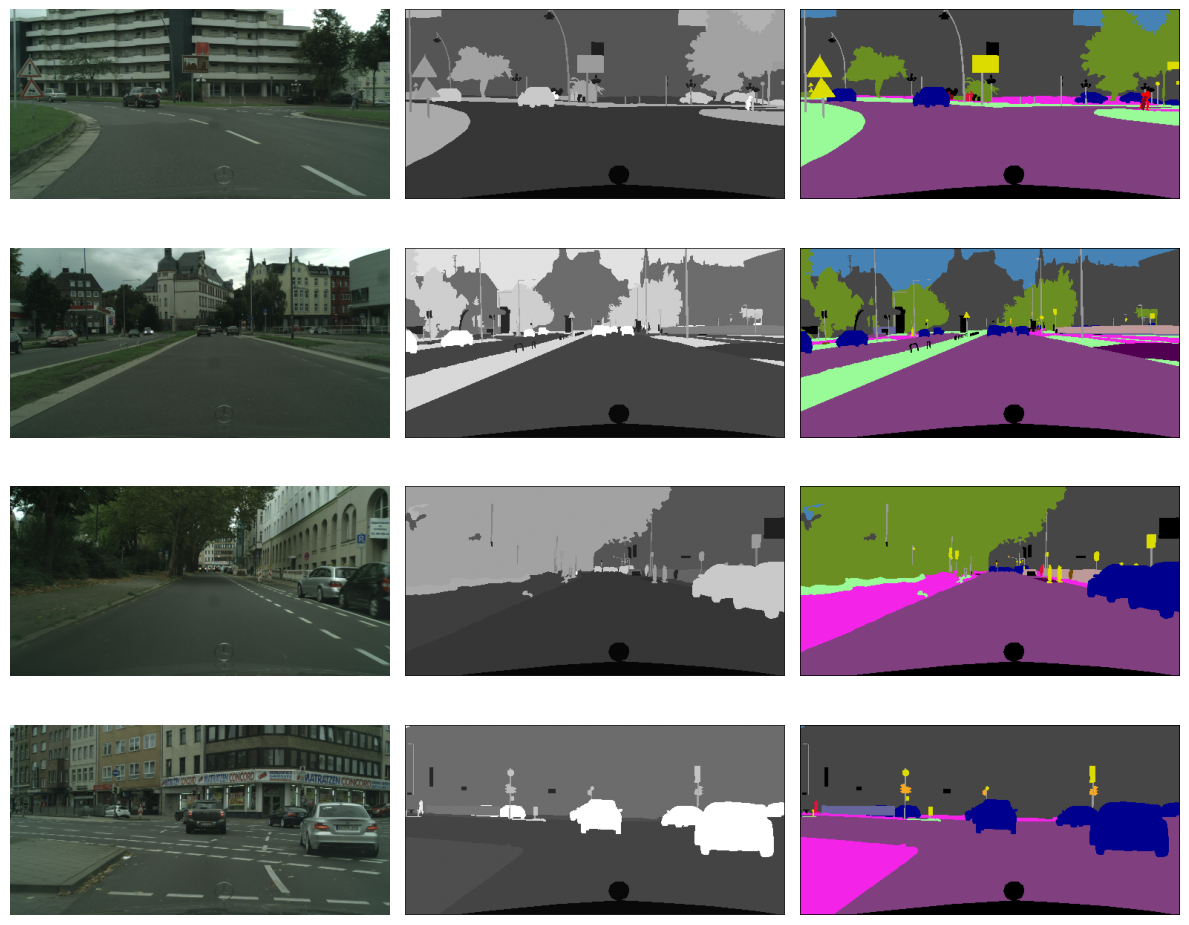

In [104]:
# Load a batch of training data and visualize it
for image_batch, annotation_grey_batch, annotation_rgb_batch in visual_ds.take(1):
    print(image.shape, annotation_grey.shape, annotation_rgb.shape)
    plt.figure(figsize=(12, 10), tight_layout=True)
    for i in range(4):
        plt.subplot(4, 3, 3 * i + 1)
        plt.imshow(image_batch[i])
        plt.axis("off")
        plt.subplot(4, 3, 3 * i + 2)
        plt.imshow(tf.squeeze(annotation_grey_batch[i]), cmap="gray")
        plt.axis("off")
        plt.subplot(4, 3, 3 * i + 3)
        plt.imshow(tf.squeeze(annotation_rgb_batch[i]))
        plt.axis("off")
    plt.show()


# Model

In [20]:
def encoder_block(inputs, num_filters):
    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.Activation("relu")(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Max Pooling with 2x2 filter
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

    return x


In [21]:
def decoder_block(inputs, skip_features, num_filters):
    # Upsampling with 2x2 filter
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        inputs
    )

    # Copy and crop the skip features
    # to match the shape of the upsampled input
    skip_features = ResizeSkipFeatures()([x, skip_features])
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x


In [22]:
class ResizeSkipFeatures(tf.keras.layers.Layer):
    def call(self, inputs):
        x, skip_features = inputs
        return tf.image.resize(skip_features, size=(tf.shape(x)[1], tf.shape(x)[2]))

In [24]:
def unet_model(input_shape=(256, 512, 3), num_classes=35):
    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(s4)
    b1 = tf.keras.layers.Activation("relu")(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(b1)
    b1 = tf.keras.layers.Activation("relu")(b1)

    # Expansive Path
    s5 = decoder_block(b1, s4, 512)
    s6 = decoder_block(s5, s3, 256)
    s7 = decoder_block(s6, s2, 128)
    s8 = decoder_block(s7, s1, 64)

    # Output
    outputs = tf.keras.layers.Conv2D(
        num_classes, (1, 1), padding="valid", activation="softmax"
    )(s8)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="U-Net")
    return model


In [25]:
model = unet_model()
model.summary()

2025-02-02 15:18:49.554657: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 512,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 512,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 256,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 256,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 128,   │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 128,   │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 128,   │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 128,   │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 64, 128,   │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 64,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 64,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,033,955 (118.39 MB)

 Trainable params: 31,033,955 (118.39 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model = unet_model()
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

In [26]:
model = unet_model()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

In [27]:
datagen = Dataloaderv3b(
    train_images[:640],
    train_masks_grey[:640],
    batch_size=8,
    target_size=TARGET_SIZE,
    num_classes=35,
    workers=NUM_WORKERS,
    use_multiprocessing=True,
    max_queue_size=5,
)

In [28]:
model.fit(datagen, epochs=1)

Number of batches: 80
Number of batches: 80
Number of batches: 80
Fetching batch 0: start_idx=0, end_idx=8
Fetching batch 1: start_idx=8, end_idx=16
Number of batches: 80
Number of batches: 80
Number of batches: 80
Fetching batch 50: start_idx=400, end_idx=408Fetching batch 53: start_idx=424, end_idx=432Fetching batch 73: start_idx=584, end_idx=592Fetching batch 68: start_idx=544, end_idx=552Fetching batch 55: start_idx=440, end_idx=448


Fetching batch 40: start_idx=320, end_idx=328


Fetching batch 69: start_idx=552, end_idx=560
Number of batches: 80
Number of batches: 80
 1/80 ━━━━━━━━━━━━━━━━━━━━ 18:46 14s/step - accuracy: 7.2479e-05 - loss: 11.0271Fetching batch 59: start_idx=472, end_idx=480
 2/80 ━━━━━━━━━━━━━━━━━━━━ 14:08 11s/step - accuracy: 0.0103 - loss: 9.7308     Fetching batch 4: start_idx=32, end_idx=40
 3/80 ━━━━━━━━━━━━━━━━━━━━ 12:14 10s/step - accuracy: 0.0471 - loss: 8.8942Fetching batch 0: start_idx=0, end_idx=8
 4/80 ━━━━━━━━━━━━━━━━━━━━ 12:37 10s/step - accuracy: 

In [29]:
model = unet_model()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

In [30]:
datagen = Dataloaderv3(
    train_images[:640],
    train_masks_grey[:640],
    batch_size=8,
    target_size=TARGET_SIZE,
    num_classes=35,
    workers=NUM_WORKERS,
    use_multiprocessing=False,
    max_queue_size=5,
)

In [31]:
model.fit(datagen, epochs=1)

Number of batches: 80
Number of batches: 80
Number of batches: 80
Fetching batch 0: start_idx=0, end_idx=8
Fetching batch 1: start_idx=8, end_idx=16
Number of batches: 80
Number of batches: 80
Number of batches: 80
Fetching batch 8: start_idx=64, end_idx=72
Fetching batch 58: start_idx=464, end_idx=472
Fetching batch 71: start_idx=568, end_idx=576
Fetching batch 50: start_idx=400, end_idx=408
Fetching batch 13: start_idx=104, end_idx=112
Fetching batch 44: start_idx=352, end_idx=360
Number of batches: 80
Number of batches: 80
Fetching batch 74: start_idx=592, end_idx=600
 1/80 ━━━━━━━━━━━━━━━━━━━━ 21:52 17s/step - accuracy: 0.0020 - loss: 8.9097Fetching batch 27: start_idx=216, end_idx=224
 2/80 ━━━━━━━━━━━━━━━━━━━━ 11:12 9s/step - accuracy: 0.0154 - loss: 8.3716 Fetching batch 7: start_idx=56, end_idx=64
 3/80 ━━━━━━━━━━━━━━━━━━━━ 12:54 10s/step - accuracy: 0.0578 - loss: 8.0785Fetching batch 3: start_idx=24, end_idx=32
 4/80 ━━━━━━━━━━━━━━━━━━━━ 12:35 10s/step - accuracy: 0.0920 - lo

In [ ]:
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image

# Load the image
img = Image.open("cat.png")
# Preprocess the image
img = img.resize((572, 572))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array[:, :, :3], axis=0)
img_array = img_array / 255.0

# Load the model
model = unet_model(input_shape=(572, 572, 3), num_classes=2)

# Make predictions
predictions = model.predict(img_array)

# Convert predictions to a numpy array and resize to original image size
predictions = np.squeeze(predictions, axis=0)
predictions = np.argmax(predictions, axis=-1)
predictions = Image.fromarray(np.uint8(predictions * 255))
predictions = predictions.resize((img.width, img.height))

# Save the predicted image
predictions.save("predicted_image.jpg")
predictions
